In [1]:
import os
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Full phenotype

In [2]:
# Chargement des données phénotypiques
phenotype_data_path = "data/Finalset_223phenotypes_1011.csv"
phenotype_df = pd.read_csv(phenotype_data_path)

In [3]:
phenotype_output_path = "data/phenotype_dataset.csv"
phenotype_df.to_csv(phenotype_output_path, index=False)
print(f"Phenotype dataset saved to {phenotype_output_path}")

Phenotype dataset saved to data/phenotype_dataset.csv


# 2. Choose the phenotype

In [20]:
phenotype = "YPD_doublingtime"
#phenotype = "YPDCUSO410MM_40h"

# 3. Filtered phenotype (which will later be ordered)

In [5]:
def filter_phenotype(phenotype):
    phenotype_data = pd.read_csv("data/phenotype_dataset.csv")
    phenotype_data = phenotype_data.rename(columns={'Standard_name': 'Yeast_ID'})
    columns_of_interest = ['Yeast_ID', phenotype]
    modified_phenotype = phenotype_data[columns_of_interest]

    # Separate the Yeast_IDs with missing values in YPD_doublingtime
    missing_yeast_ids = modified_phenotype.loc[modified_phenotype[phenotype].isna(), "Yeast_ID"].tolist()

    # Remove rows with missing values in YPD_doublingtime
    filtered_phenotype = modified_phenotype.dropna(subset=[phenotype])
    return missing_yeast_ids, filtered_phenotype

missing_yeast_ids, filtered_phenotype = filter_phenotype(phenotype)

# 4. Copy number variations dataset

In [21]:
# Chargement des données de variation du nombre de copies
copy_number_variation_path = "data/genesMatrix_CopyNumber.tab"
cnv_df = pd.read_csv(copy_number_variation_path, sep="\t", index_col=0).T
cnv_df.index.name = "Standard_name"
cnv_df.reset_index(inplace=True)

# Define the updated pattern (only checks the beginning of the string)
pattern = r'^X\d{1,4}\.Y[A-Z]{2}\d{3}[A-Z]'

# Keep rows where 'Standard_name' begins with the pattern
cnv_df = cnv_df[cnv_df['Standard_name'].str.match(pattern, na=False)]

# Reset the index
cnv_df = cnv_df.reset_index(drop=True)

# Define regex patterns for the two cases
pattern_case1 = r'Y[A-Z]{2}\d{3}[A-Z]'  # For case 1: "Y" + 2 uppercase letters + 3 digits + 1 uppercase letter
pattern_case2 = r'Y[A-Z]{2}\d{3}[A-Z]\.[A-Z]'  # For case 2: Same as case 1, but with ".X" at the end

# Function to extract the real name
def extract_real_name(name):
    import re
    # Check case 2 first (more specific pattern)
    match_case2 = re.search(pattern_case2, name)
    if match_case2:
        # Replace '.' with '-'
        return match_case2.group().replace('.', '-')
    # Check case 1
    match_case1 = re.search(pattern_case1, name)
    if match_case1:
        return match_case1.group()
    # Return None if no match
    return None

# Apply the function to extract real names
cnv_df['Standard_name'] = cnv_df['Standard_name'].apply(extract_real_name)

# Drop rows with no real name (optional)
cnv_df = cnv_df.dropna(subset=['Standard_name']).reset_index(drop=True)

# Fill missing values in columns except the first one with the median of that column directly in the original df
cnv_df.iloc[:, 1:] = cnv_df.iloc[:, 1:].fillna(cnv_df.median(numeric_only=True))


In [22]:
cnv_output_path = "data/copy_number_variation_dataset.csv"
cnv_df.to_csv(cnv_output_path, index=False)
print(f"Copy number variation dataset saved to {cnv_output_path}")

Copy number variation dataset saved to data/copy_number_variation_dataset.csv


# 5. Mutations of each yeast on each protein dataset

In [ ]:
proteome_dir_path = "data/Proteome_1011"  # Dossier contenant les fichiers de séquences protéiques

# Liste pour stocker les données de mutation
mutations = []

# Parcourir chaque fichier dans le dossier des protéines
for filename in os.listdir(proteome_dir_path):
    if filename.endswith(".fasta"):
        filepath = os.path.join(proteome_dir_path, filename)
        protein_id = filename.split(".")[0]  # Nom de la protéine
        
        # Lecture des séquences du fichier FASTA
        sequences = {}
        with open(filepath, "r") as file:
            current_yeast = None
            for line in file:
                if line.startswith(">"):  # Identifiant de la levure
                    header = line.strip().split()[0][1:]  # Retirer le ">"
                    # Extraire le nom de la levure avant le nom de la protéine
                    current_yeast = header.split(f"_{protein_id}", 1)[0]
                    
                    sequences[current_yeast] = ""
                else:
                    sequences[current_yeast] += line.strip()
        
        # Transposer les séquences pour analyser position par position
        yeast_ids = list(sequences.keys())
        transposed_positions = zip(*sequences.values())  # Colonne par colonne
        
        # Identifier les mutations par rapport à l'acide aminé majoritaire
        for idx, amino_acids in enumerate(transposed_positions, start=1):
            aa_counts = Counter(amino_acids)
            most_common_aa, _ = aa_counts.most_common(1)[0]  # Acide aminé majoritaire
            
            
            for yeast_id, aa in zip(yeast_ids, amino_acids):
                if aa != most_common_aa:  # Mutation détectée
                    mutations.append({
                        "Protein_ID": protein_id,
                        "Yeast_ID": yeast_id,
                        "Position": idx,
                        "Reference_AA": most_common_aa,
                        "Mutated_AA": aa
                    })

# Convertir les mutations en DataFrame
mutations_df = pd.DataFrame(mutations)

In [ ]:
mutations_output_path = "data/mutations_dataset.csv"
mutations_df.to_csv(mutations_output_path, index=False)
print(f"Mutations dataset saved to {mutations_output_path}")

NameError: name 'mutations_df' is not defined

# 6. Extended mutation matrix

In [6]:
def create_mutation_matrix(df, min_mutations=2):
    # Filter out rows with Yeast_IDs in the missing_yeast_ids list
    df = df[~df['Yeast_ID'].isin(missing_yeast_ids)].copy()  # Use .copy() to avoid SettingWithCopyWarning

    # Create mutation labels
    df.loc[:, 'Mutation_Label'] = (
        df['Protein_ID'] + '_' +
        df['Position'].astype(str) + '_' +
        df['Reference_AA'] + '->' + df['Mutated_AA']
    )

    # Drop duplicates to ensure each mutation appears only once per yeast
    df = df.drop_duplicates(subset=['Yeast_ID', 'Mutation_Label'])
    
    # Pivot the data to create a matrix, use Yeast_ID as index and Mutation_Label as columns
    mutation_matrix = df.pivot(index='Yeast_ID', 
                               columns='Mutation_Label', 
                               values='Mutation_Label')
    
    # Fill missing values with 0 and set the presence of mutation to 1
    mutation_matrix = mutation_matrix.notnull().astype(int)
    
    # Number of mutations (mutation labels) before filtering
    num_mutations_before = mutation_matrix.shape[1]
    print(f"Number of mutations before filtering: {num_mutations_before}")
    
    # Filter out columns with less than min_mutations occurrences
    mutation_matrix = mutation_matrix.loc[:, (mutation_matrix.sum(axis=0) >= min_mutations)]
    
    # Number of mutations (mutation labels) after filtering
    num_mutations_after = mutation_matrix.shape[1]
    print(f"Number of mutations after filtering: {num_mutations_after}")
    
    # Reset index to include Yeast_ID as a column
    mutation_matrix.reset_index(inplace=True)
    
    return mutation_matrix


dtype_dict = {
    'Yeast_ID': str,          # Yeast_ID might be a string
    'Protein_ID': str,        # Protein_ID might be a string
    'Position': str,          # Position might be a string
    'Reference_AA': str,      # Reference_AA might be a string
    'Mutated_AA': str,        # Mutated_AA might be a string
}

mutations_data = pd.read_csv("data/mutations_dataset.csv", dtype=dtype_dict)

mutation_matrix = create_mutation_matrix(mutations_data)

KeyboardInterrupt: 

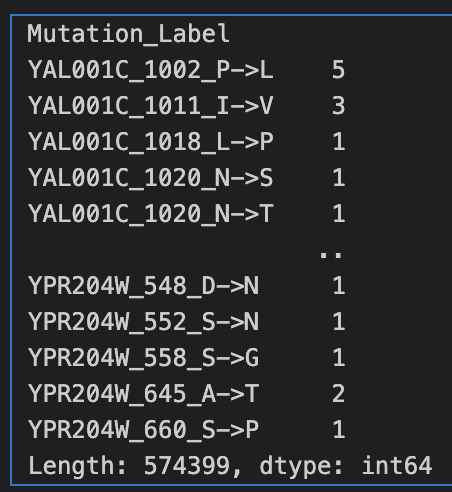


In [24]:
extended_mutations_output_path = f"data/extended_mutations_{phenotype}.csv"
mutation_matrix.to_csv(extended_mutations_output_path, index=False)
print(f"Extended mutations dataset saved to {extended_mutations_output_path}")

Extended mutations dataset saved to data/extended_mutations_YPDCUSO410MM_40h.csv


# 7. X matrix

In [25]:
# Chemins des fichiers
cnv_path = "data/copy_number_variation_dataset.csv"

# Étape 1 : Charger les fichiers nécessaires
print("Étape 1 : Chargement des données CNV avec Pandas...")
cnv_data = pd.read_csv(cnv_path)
print("CNV data chargée avec succès.")

# Étape 2 : Utiliser directement la matrice de mutation en mémoire car moins long
print("Utilisation de la matrice de mutations en mémoire...")
#mutation_matrix = pd.read_csv(f"data/extend_mutations_{phenotype}.csv")


# Étape 3 : Identifier les protéines uniques dans la matrice de mutation
print("Étape 4 : Identification des protéines uniques dans la matrice de mutations...")
mutation_column_names = mutation_matrix.columns[1:]  # Ignorer la colonne 'Yeast_ID'
protein_columns = [col.split('_')[0] for col in mutation_column_names]
unique_proteins = set(protein_columns)
print(f"Nombre de protéines avec mutations : {len(unique_proteins)}")


# CETTE ÉTAPE EST POUR ENLEVER LES PROTEINES SANS MUTATION
'''
# Étape 4 : Filtrer CNV data pour inclure seulement les protéines uniques, qui ont minimum 1 (ou 2) mutation
print("Étape 5 : Filtrage des données CNV...")
print(f"Nombre de protéines de CNV : {cnv_data.shape[0]}")
filtered_cnv_data = cnv_data[cnv_data['Standard_name'].isin(unique_proteins)]
print(f"Filtrage CNV terminé, sans les protéines sans mutation. Nombre de protéines restantes : {filtered_cnv_data.shape[0]}")
'''

# CETTE ÉTAPE EST POUR COMPLÉTER NOTRE CNV
'''
# Étape 5 : Calculer les valeurs médianes pour les protéines manquantes
print("Étape 6 : Calcul des valeurs médianes pour les protéines avec mutations, manquantes chez CNV...")
missing_proteins = unique_proteins - set(filtered_cnv_data['Standard_name'])
if missing_proteins:
    print(f"Nombre de protéines manquantes détectées : {len(missing_proteins)}")
    median_values = filtered_cnv_data.drop(columns=['Standard_name']).median()
    print("Calcul des médianes terminé.")

    # Ajouter les protéines manquantes avec les valeurs médianes
    for protein in missing_proteins:
        new_row = pd.Series({'Standard_name': protein, **median_values})
        filtered_cnv_data = pd.concat([filtered_cnv_data, new_row.to_frame().T], ignore_index=True)
    print("Ajout des protéines manquantes terminé.")
else:
    print("Aucune protéine manquante détectée.")
print(f"Update CNV terminée, sans les protéines sans mutation, avec les protéines qu'il lui manquait. Nombre de protéines restantes : {filtered_cnv_data.shape[0]}")
'''
print(f"Nombre de protéines de CNV : {cnv_data.shape[0]}")

# Étape 6 : Transposer les données CNV filtrées
print("Étape 7 : Transposition des données CNV...")
#filtered_cnv_transposed = filtered_cnv_data.set_index('Standard_name').transpose()
filtered_cnv_transposed = cnv_data.set_index('Standard_name').transpose()
print("Transposition CNV terminée.")

# Étape 7 : Fusionner mutation_matrix et filtered_cnv_transposed
print("Étape 8 : Fusion des matrices de mutations et CNV...")
X_matrix = mutation_matrix.merge(
    filtered_cnv_transposed, 
    left_on='Yeast_ID', 
    right_index=True, 
    how='left'
)
print(f"Fusion terminée. Dimensions de X_matrix : {X_matrix.shape}")

Étape 1 : Chargement des données CNV avec Pandas...
CNV data chargée avec succès.
Utilisation de la matrice de mutations en mémoire...
Étape 4 : Identification des protéines uniques dans la matrice de mutations...
Nombre de protéines avec mutations : 6474
Nombre de protéines de CNV : 6051
Étape 7 : Transposition des données CNV...
Transposition CNV terminée.
Étape 8 : Fusion des matrices de mutations et CNV...
Fusion terminée. Dimensions de X_matrix : (971, 374347)


In [26]:
X_matrix_output_path = f"data/X_matrix_{phenotype}.csv"
X_matrix.to_csv(X_matrix_output_path, index=False)
print(f"Combined matrix X saved to {X_matrix_output_path}")

Combined matrix X saved to data/X_matrix_YPDCUSO410MM_40h.csv


# 8. y phenotype

In [27]:
# Order the phenotype
y_phenotype = filtered_phenotype.set_index('Yeast_ID').reindex(X_matrix['Yeast_ID']).reset_index()

In [28]:
y_phenotype_output_path = f"data/y_{phenotype}.csv"
y_phenotype.to_csv(y_phenotype_output_path, index=False)
print(f"Ordered phenotype saved to {y_phenotype_output_path}")

Ordered phenotype saved to data/y_YPDCUSO410MM_40h.csv


# 9. Plots

## 9.a y phenotype distribution

The median of the column is: 0.339164466


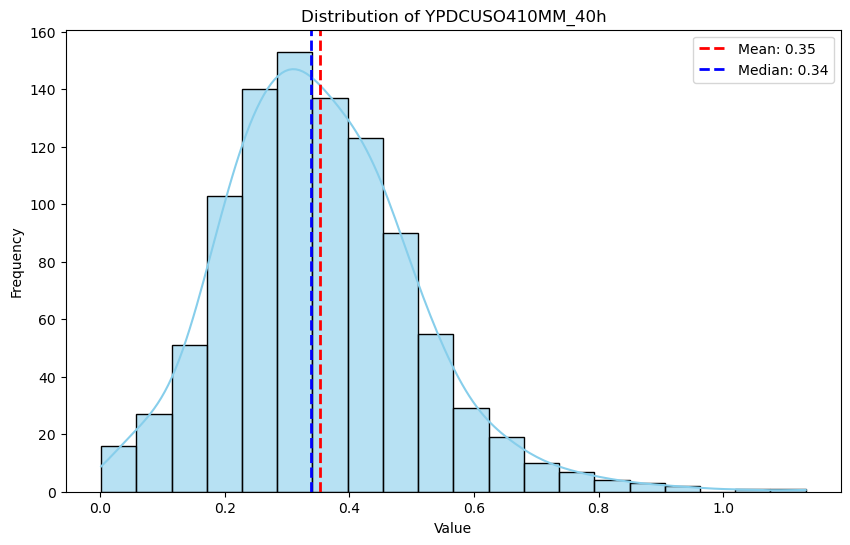

In [13]:
y_data = y_phenotype.drop(columns=["Yeast_ID"])

median_value = y_data[phenotype].median()
print(f"The median of the column is: {median_value}")

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot histogram for the single column with KDE
sns.histplot(y_data[phenotype], kde=True, bins=20, color='skyblue', alpha=0.6)

# Calculate mean and median
mean_val = y_data[phenotype].mean()
median_val = y_data[phenotype].median()

# Plot lines for mean and median
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')

# Add title and labels
plt.title(f'Distribution of {phenotype}')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Save the plot to a file (e.g., as a PNG file)
plt.savefig(f'results/plots/y_{phenotype}.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## 9.b Extended mutations matrix distribution

In [21]:
import numpy as np
import pandas as pd

print("Loading the data...")
X_file = f"data/X_matrix_{phenotype}.csv"

# Load the column names (header)
column_names = np.genfromtxt(X_file, delimiter=',', max_rows=1, dtype=str)[1:]  # Skip the first column if it's row names

# Read the first line of the file to determine the number of columns
with open(X_file, 'r') as f:
    first_line = f.readline()
    end_column_index = len(first_line.split(','))  # Count the number of columns in the first line

# Load the row names (index) from the first column and the data (excluding first column)
data = np.loadtxt(X_file, delimiter=',', skiprows=1, usecols=range(1, end_column_index))
row_names = np.loadtxt(X_file, delimiter=',', skiprows=1, usecols=0, dtype=str)

# Create the DataFrame
X_data = pd.DataFrame(data, index=row_names, columns=column_names)

print(f"Dimensions de X : {X_data.shape}")


Loading the data...
Dimensions de X : (792, 347952)


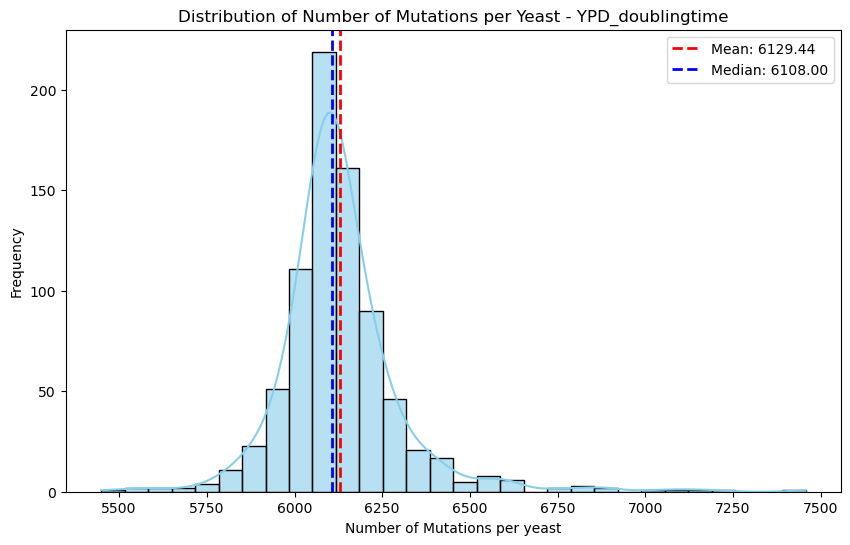

In [22]:
#X_data = X_matrix.drop(columns=["Yeast_ID"])
num_last_columns = cnv_data.shape[0]

# Calculate the number of mutations per yeast (i.e., sum across each row)
mutation_counts = X_data.iloc[:, -num_last_columns:].sum(axis=1)

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot the distribution using Seaborn
sns.histplot(mutation_counts, kde=True, bins=30, color='skyblue', alpha=0.6)

# Calculate mean and median
mean_val = mutation_counts.mean()
median_val = mutation_counts.median()

# Plot lines for mean and median
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')

# Add title and labels
plt.title(f'Distribution of Number of Mutations per Yeast - {phenotype}')
plt.xlabel('Number of Mutations per yeast')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Save the plot to a file (e.g., as a PNG file)
plt.savefig(f'results/plots/mutation_per_yeast_{phenotype}.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

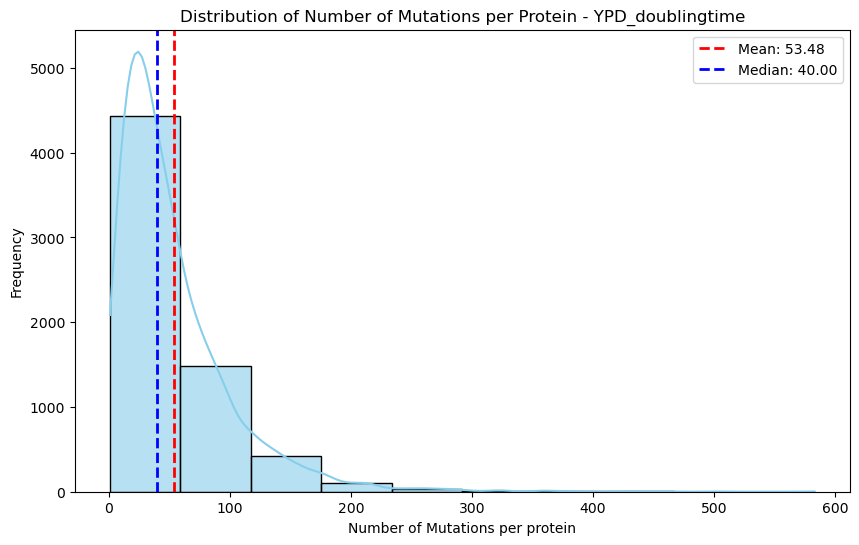

In [23]:
# Step 1: Extract protein names from the DataFrame's column names (keys)
proteins = [col.split('_')[0] for col in X_data.columns]

# Step 2: Count how many mutations are associated with each protein
mutation_counts = Counter(proteins)

# Step 3: Convert the mutation counts into a pandas DataFrame for easy plotting
mutation_df = pd.DataFrame(list(mutation_counts.items()), columns=['Protein', 'Mutation Count'])

# Step 4: Plot the distribution of the number of mutations per protein
plt.figure(figsize=(10, 6))
sns.histplot(mutation_df['Mutation Count'], kde=True, bins=10, color='skyblue', alpha=0.6)

# Calculate mean and median
mean_val = mutation_df['Mutation Count'].mean()
median_val = mutation_df['Mutation Count'].median()

# Plot lines for mean and median
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')

# Add title and labels
plt.title(f'Distribution of Number of Mutations per Protein - {phenotype}')
plt.xlabel('Number of Mutations per protein')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Save the plot to a file (e.g., as a PNG file)
plt.savefig(f'results/plots/mutation_per_protein_{phenotype}.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## 9.c CNV data

/var/folders/hc/f0q04dfj06d1b1f0nks6jk_00000gn/T/ipykernel_20428/3551109344.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


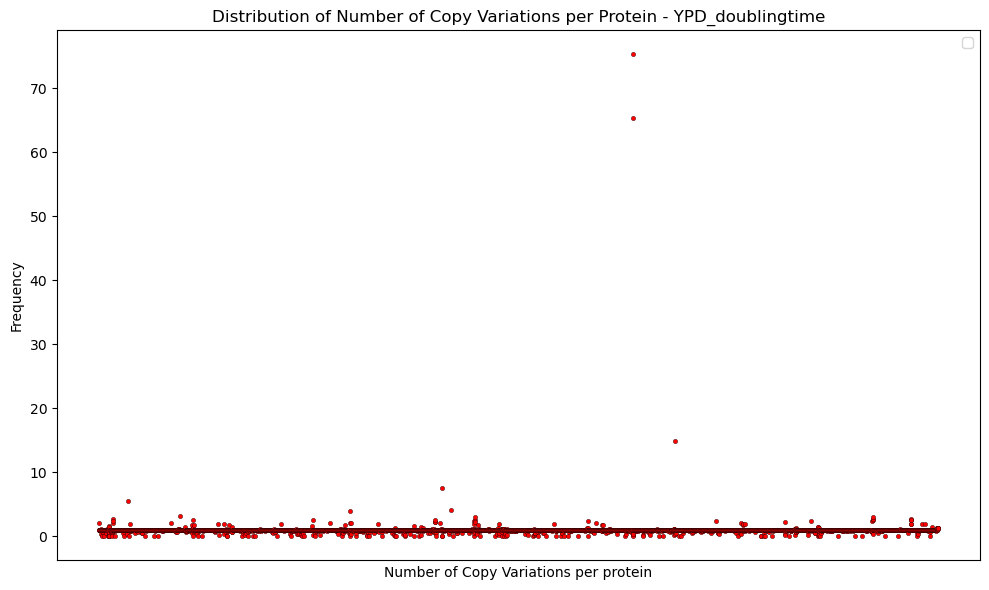

<Figure size 640x480 with 0 Axes>

In [36]:
# Select the last N columns
num_last_columns = cnv_data.shape[0]
target_columns = X_data.iloc[:, -num_last_columns:]

# Step 2: Compute the mean number of copy variations for each protein
protein_mean_variations = target_columns.mean(axis=0)  # Compute the mean for each protein (column)

# Step 3: Create a histogram for the distribution of copy variations
plt.figure(figsize=(10, 6))

# Scatter plot: We use scatterplot to plot the count of mutations for each protein
sns.scatterplot(x=protein_mean_variations.index, y=protein_mean_variations.values, color='red', s=10, edgecolor='black')

# Calculate mean and median
mean_val = protein_mean_variations.mean()
median_val = protein_mean_variations.median()

# Set the x-axis limits to avoid unnecessary space
plt.xticks(rotation=45, ha='right')

# Add titles and labels
plt.title(f'Distribution of Number of Copy Variations per Protein - {phenotype}')
plt.xlabel('Number of Copy Variations per protein')
plt.ylabel('Frequency')

# Remove x-axis labels
plt.xticks([])

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot to a file (e.g., as a PNG file)
plt.savefig(f'results/plots/CNV_per_protein_{phenotype}.png', dpi=300, bbox_inches='tight')
